This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-24 17:15:14--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.68.152, 52.217.167.184, 52.217.85.222, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.68.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  57.9MB/s    in 0.2s    

2023-11-24 17:15:14 (57.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines_data_data = data.split("\n")
header = lines_data_data[0].split(",")
lines_data_data= lines_data_data[1:]
print(header)
print(len(lines_data_data))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines_data),))
raw_data = np.zeros((len(lines_data), len(header) - 1))
for i, line in enumerate(lines_data):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

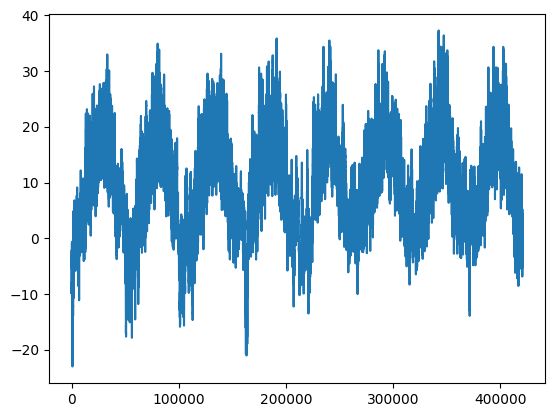

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

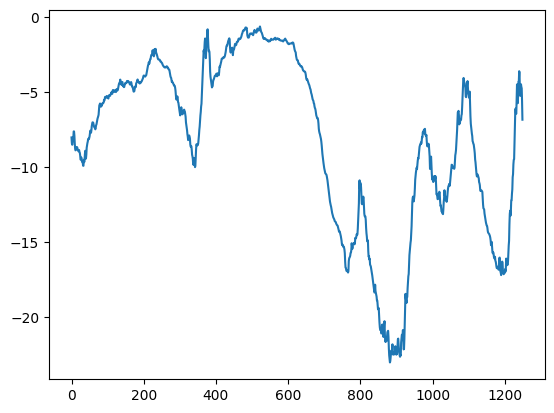

In [6]:
plt.plot(range(1250), temperature[:1250])

**Computing the number of samples we'll use for each data split**

In [7]:
num_training_samples = int(0.2 * len(raw_data))
num_validation_samples = int(0.15 * len(raw_data))
num_test_samples = len(raw_data) - num_training_samples - num_validation_samples
print("num_training_samples:", num_training_samples)
print("num_validation_samples:", num_validation_samples)
print("num_test_samples:", num_test_samples)

num_training_samples: 84090
num_validation_samples: 63067
num_test_samples: 273294


### Preparing the data

**Normalizing the data**

In [8]:
mean = raw_data[:num_training_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_training_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
initial_sequence = np.arange(10)
dummy_data = keras.utils.timeseries_dataset_from_array(
    data=initial_sequence[:-2],
    targets=initial_sequence[2:],
    sequence_length=4,
    batch_size=1,
)

for inputs, targets in dummy_data:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2, 3] 2
[1, 2, 3, 4] 3
[2, 3, 4, 5] 4
[3, 4, 5, 6] 5
[4, 5, 6, 7] 6


**Instantiating datasets for training, validation, and testing**

In [13]:
sampling_rate = 4
sequence_length = 80
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 128

training_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_training_samples)

validation_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_training_samples,
    end_index=num_training_samples + num_validation_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_training_samples + num_validation_samples)

**Inspecting the output of one of our datasets**

In [14]:
for samples, targets in training_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (128, 80, 14)
targets shape: (128,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [15]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(validation_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 4.53
Test MAE: 4.08


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 [==============================] - 24s 35ms/step - loss: 12.0561 - mae: 2.6373 - val_loss: 10.9882 - val_mae: 2.6512
Epoch 2/10
655/655 [==============================] - 28s 43ms/step - loss: 7.4430 - mae: 2.1422 - val_loss: 10.2098 - val_mae: 2.5230
Epoch 3/10
655/655 [==============================] - 24s 36ms/step - loss: 6.8447 - mae: 2.0530 - val_loss: 9.2228 - val_mae: 2.4044
Epoch 4/10
655/655 [==============================] - 23s 35ms/step - loss: 6.4936 - mae: 2.0009 - val_loss: 9.9730 - val_mae: 2.4938
Epoch 5/10
655/655 [==============================] - 25s 38ms/step - loss: 6.2262 - mae: 1.9570 - val_loss: 10.5534 - val_mae: 2.5584
Epoch 6/10
655/655 [==============================] - 24s 36ms/step - loss: 6.0423 - mae: 1.9302 - val_loss: 9.8250 - val_mae: 2.4900
Epoch 7/10
655/655 [==============================] - 22s 33ms/step - loss: 5.8722 - mae: 1.9014 - val_loss: 10.9083 - val_mae: 2.6558
Epoch 8/10
655/655 [==============================] - 24s

**Plotting results**

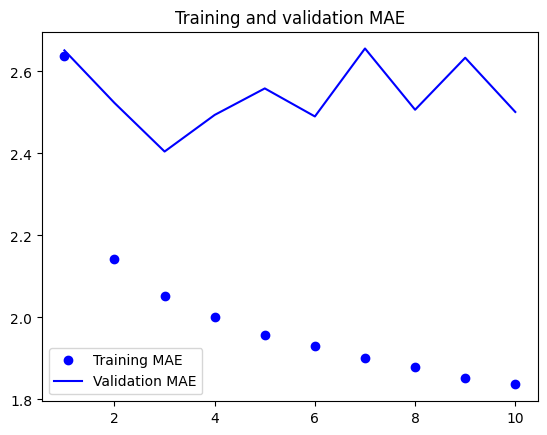

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
validation_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, validation_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 [==============================] - 34s 50ms/step - loss: 14.2833 - mae: 2.8462 - val_loss: 11.2319 - val_mae: 2.6305
Epoch 2/10
655/655 [==============================] - 33s 50ms/step - loss: 9.3119 - mae: 2.3818 - val_loss: 12.0720 - val_mae: 2.7083
Epoch 3/10
655/655 [==============================] - 32s 48ms/step - loss: 8.6992 - mae: 2.3007 - val_loss: 11.7154 - val_mae: 2.7494
Epoch 4/10
655/655 [==============================] - 41s 62ms/step - loss: 8.2201 - mae: 2.2391 - val_loss: 10.5506 - val_mae: 2.5580
Epoch 5/10
655/655 [==============================] - 42s 64ms/step - loss: 7.9000 - mae: 2.2009 - val_loss: 10.5427 - val_mae: 2.5613
Epoch 6/10
655/655 [==============================] - 45s 69ms/step - loss: 7.6101 - mae: 2.1600 - val_loss: 10.4252 - val_mae: 2.5605
Epoch 7/10
655/655 [==============================] - 32s 48ms/step - loss: 7.3785 - mae: 2.1292 - val_loss: 11.3217 - val_mae: 2.6281
Epoch 8/10
655/655 [==============================] - 

### A first recurrent baseline

**A simple LSTM-based model**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 [==============================] - 56s 83ms/step - loss: 46.0940 - mae: 4.9396 - val_loss: 15.9329 - val_mae: 3.0985
Epoch 2/10
655/655 [==============================] - 59s 90ms/step - loss: 10.8692 - mae: 2.4988 - val_loss: 11.1636 - val_mae: 2.6409
Epoch 3/10
655/655 [==============================] - 60s 91ms/step - loss: 7.9320 - mae: 2.1790 - val_loss: 10.4769 - val_mae: 2.5485
Epoch 4/10
655/655 [==============================] - 52s 79ms/step - loss: 7.1629 - mae: 2.0701 - val_loss: 10.3823 - val_mae: 2.5290
Epoch 5/10
655/655 [==============================] - 57s 86ms/step - loss: 6.7001 - mae: 1.9973 - val_loss: 10.7269 - val_mae: 2.5684
Epoch 6/10
655/655 [==============================] - 49s 75ms/step - loss: 6.3327 - mae: 1.9444 - val_loss: 10.5503 - val_mae: 2.5524
Epoch 7/10
655/655 [==============================] - 51s 78ms/step - loss: 5.9967 - mae: 1.8942 - val_loss: 10.4493 - val_mae: 2.5389
Epoch 8/10
655/655 [==============================] -

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [23]:
import numpy as np
timesteps = 50
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [24]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [25]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [26]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 80, 16)


**Stacking RNN layers**

In [27]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.15)(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
655/655 [==============================] - 119s 177ms/step - loss: 52.7371 - mae: 5.3603 - val_loss: 16.4344 - val_mae: 3.1248
Epoch 2/30
655/655 [==============================] - 84s 127ms/step - loss: 16.3600 - mae: 3.0754 - val_loss: 10.7142 - val_mae: 2.5842
Epoch 3/30
655/655 [==============================] - 92s 141ms/step - loss: 13.4299 - mae: 2.8229 - val_loss: 10.4047 - val_mae: 2.5486
Epoch 4/30
655/655 [==============================] - 89s 136ms/step - loss: 12.6786 - mae: 2.7397 - val_loss: 10.4252 - val_mae: 2.5504
Epoch 5/30
655/655 [==============================] - 95s 145ms/step - loss: 12.1285 - mae: 2.6824 - val_loss: 9.9555 - val_mae: 2.4782
Epoch 6/30
655/655 [==============================] - 90s 137ms/step - loss: 11.6704 - mae: 2.6378 - val_loss: 9.7065 - val_mae: 2.4414
Epoch 7/30
655/655 [==============================] - 85s 129ms/step - loss: 11.4376 - mae: 2.6044 - val_loss: 9.5708 - val_mae: 2.4310
Epoch 8/30
655/655 [=======================

In [29]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.1, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.2   )(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
655/655 [==============================] - 137s 202ms/step - loss: 50.7068 - mae: 5.1965 - val_loss: 15.2346 - val_mae: 2.9402
Epoch 2/30
655/655 [==============================] - 131s 200ms/step - loss: 19.1476 - mae: 3.2825 - val_loss: 10.9383 - val_mae: 2.6112
Epoch 3/30
655/655 [==============================] - 132s 202ms/step - loss: 16.4749 - mae: 3.0787 - val_loss: 9.6393 - val_mae: 2.4333
Epoch 4/30
655/655 [==============================] - 131s 200ms/step - loss: 15.4667 - mae: 2.9943 - val_loss: 9.5380 - val_mae: 2.4156
Epoch 5/30
655/655 [==============================] - 126s 192ms/step - loss: 14.5947 - mae: 2.9121 - val_loss: 9.9084 - val_mae: 2.4826
Epoch 6/30
655/655 [==============================] - 123s 187ms/step - loss: 14.2089 - mae: 2.8754 - val_loss: 9.7286 - val_mae: 2.4536
Epoch 7/30
655/655 [==============================] - 126s 193ms/step - loss: 13.5694 - mae: 2.8140 - val_loss: 9.8786 - val_mae: 2.4714
Epoch 8/30
655/655 [===================

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(8))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
655/655 [==============================] - 69s 100ms/step - loss: 48.5479 - mae: 5.1864 - val_loss: 20.7927 - val_mae: 3.5726
Epoch 2/10
655/655 [==============================] - 69s 106ms/step - loss: 13.8837 - mae: 2.8609 - val_loss: 14.5841 - val_mae: 2.9889
Epoch 3/10
655/655 [==============================] - 64s 97ms/step - loss: 9.8508 - mae: 2.4223 - val_loss: 13.1339 - val_mae: 2.8381
Epoch 4/10
655/655 [==============================] - 68s 104ms/step - loss: 8.6233 - mae: 2.2680 - val_loss: 12.3077 - val_mae: 2.7491
Epoch 5/10
655/655 [==============================] - 70s 106ms/step - loss: 8.0281 - mae: 2.1894 - val_loss: 11.7446 - val_mae: 2.6876
Epoch 6/10
655/655 [==============================] - 64s 98ms/step - loss: 7.5676 - mae: 2.1298 - val_loss: 11.6286 - val_mae: 2.6722
Epoch 7/10
655/655 [==============================] - 70s 106ms/step - loss: 7.2588 - mae: 2.0858 - val_loss: 11.0879 - val_mae: 2.6193
Epoch 8/10
655/655 [============================

### Going even further

## Summary